# Sea level

In [1]:
using Distributions, Compat, Plots, Random, CSV, DataFrames, GLM
# plotly()
upscale = 1
default(line = (:steppre, 0.5, 1, 2), size=(800*upscale,600*upscale))

In diesem Abschnitt werden wir mit realen Daten arbeiten. Dazu nutzen wir die Entwicklung der Meeresspiegel für Monaten. Die Daten stammen von [hier](https://datahub.io/core/sea-level-rise).

Wir lesen die Datei ein, entfernen fehlende Werte und erhalten:

In [2]:
data = CSV.File("sea-level.csv") |> DataFrame # Read csv
data[:GMSL] = convert(Array{Float64, 1}, data[:GMSL]) # Convert col to number

data[:Row] = collect(1:size(data)[1]) # Add row number for linear regression
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Union…,DataType
1,Time,,1993-01-15,,2015-02-15,266,0,Date
2,GMSL,36.0286,-3.5,36.7,79.5,,,Float64
3,Row,133.5,1,133.5,266,,,Int64


Die Spalten sind wie folg:

- Time: Tag genau Datum der Erfassung
- GMSL: Global Mean Sea Level, dt. globale durschnittliche Meeresspiegel. Einheit ist in `mm`.
- Row: Wir fügen eine zusätzliche Nummerierung der Spalten ein.

In [3]:
first(data, 6)

,Time,GMSL,Row
,Dates…⍰,Float64,Int64
1,1993-01-15,-1.6,1
2,1993-02-15,-3.4,2
3,1993-03-15,5.5,3
4,1993-04-15,0.1,4
5,1993-05-15,5.3,5
6,1993-06-15,0.2,6


Die Entwicklung der Meeresspiegel ist folgendes:

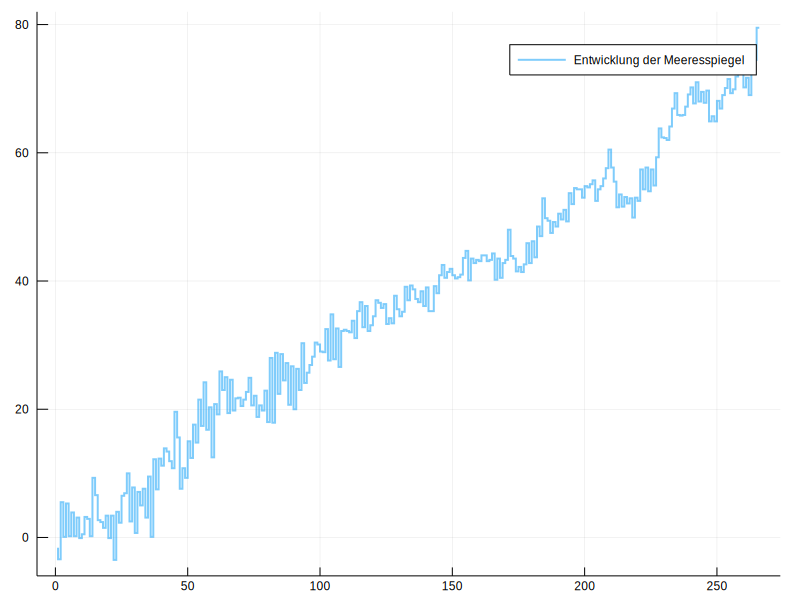

In [4]:
# range = 0:270
plot(data[:Row], data[:GMSL], label = "Entwicklung der Meeresspiegel")

In [5]:
linearmodel = fit(LinearModel, @formula(GMSL ~ Row), data)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: GMSL ~ 1 + Row

Coefficients:
             Estimate  Std.Error  t value Pr(>|t|)
(Intercept)  0.253225   0.415202 0.609883   0.5425
Row           0.26798 0.00269597  99.4001   <1e-99


In [6]:
coef(linearmodel)
error = stderror(linearmodel)[1]

0.415201779211427

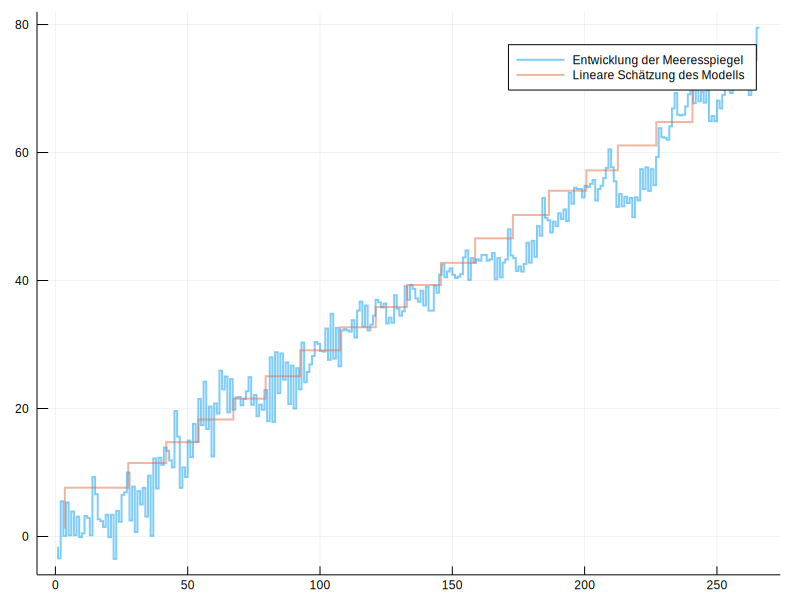

In [7]:
f(x) = coef(linearmodel)[2] * x + coef(linearmodel)[1]
plot!(f, 1, size(data)[1], label = "Lineare Schätzung des Modells")

In [8]:
include("../KalmanFilter.jl")
import .KalmanFilter

Fusion:  K -0.120    x̂ -1.600    Σ -1.792
Predict: x̂ -1.600    Σ -1.292
Fusion:  K -0.095    x̂ -1.430    Σ -1.414
Predict: x̂ -1.430    Σ -0.914
Fusion:  K -0.065    x̂ -1.881    Σ -0.973
Predict: x̂ -1.881    Σ -0.473
Fusion:  K -0.033    x̂ -1.945    Σ -0.489
Predict: x̂ -1.945    Σ 0.011
Fusion:  K 0.001    x̂ -1.940    Σ 0.011
Predict: x̂ -1.940    Σ 0.511
Fusion:  K 0.033    x̂ -1.869    Σ 0.495
Predict: x̂ -1.869    Σ 0.995
Fusion:  K 0.062    x̂ -1.510    Σ 0.933
Predict: x̂ -1.510    Σ 1.433
Fusion:  K 0.087    x̂ -1.360    Σ 1.307
Predict: x̂ -1.360    Σ 1.807
Fusion:  K 0.108    x̂ -0.879    Σ 1.612
Predict: x̂ -0.879    Σ 2.112
Fusion:  K 0.124    x̂ -0.783    Σ 1.851
Predict: x̂ -0.783    Σ 2.351
Fusion:  K 0.136    x̂ -0.609    Σ 2.032
Predict: x̂ -0.609    Σ 2.532
Fusion:  K 0.145    x̂ -0.057    Σ 2.165
Predict: x̂ -0.057    Σ 2.665
Fusion:  K 0.151    x̂ 0.390    Σ 2.262
Predict: x̂ 0.390    Σ 2.762
Fusion:  K 0.156    x̂ 0.360    Σ 2.332
Predict: x̂ 0.360    Σ 2.832

Fusion:  K 0.167    x̂ 36.867    Σ 2.496
Predict: x̂ 36.867    Σ 2.996
Fusion:  K 0.167    x̂ 37.123    Σ 2.496
Predict: x̂ 37.123    Σ 2.996
Fusion:  K 0.167    x̂ 36.952    Σ 2.496
Predict: x̂ 36.952    Σ 2.996
Fusion:  K 0.167    x̂ 37.294    Σ 2.496
Predict: x̂ 37.294    Σ 2.996
Fusion:  K 0.167    x̂ 36.961    Σ 2.496
Predict: x̂ 36.961    Σ 2.996
Fusion:  K 0.167    x̂ 36.684    Σ 2.496
Predict: x̂ 36.684    Σ 2.996
Fusion:  K 0.167    x̂ 37.104    Σ 2.496
Predict: x̂ 37.104    Σ 2.996
Fusion:  K 0.167    x̂ 37.270    Σ 2.496
Predict: x̂ 37.270    Σ 2.996
Fusion:  K 0.167    x̂ 37.876    Σ 2.496
Predict: x̂ 37.876    Σ 2.996
Fusion:  K 0.167    x̂ 38.647    Σ 2.496
Predict: x̂ 38.647    Σ 2.996
Fusion:  K 0.167    x̂ 38.957    Σ 2.496
Predict: x̂ 38.957    Σ 2.996
Fusion:  K 0.167    x̂ 39.364    Σ 2.496
Predict: x̂ 39.364    Σ 2.996
Fusion:  K 0.167    x̂ 39.787    Σ 2.496
Predict: x̂ 39.787    Σ 2.996
Fusion:  K 0.167    x̂ 39.973    Σ 2.496
Predict: x̂ 39.973    Σ 2.996
Fusion

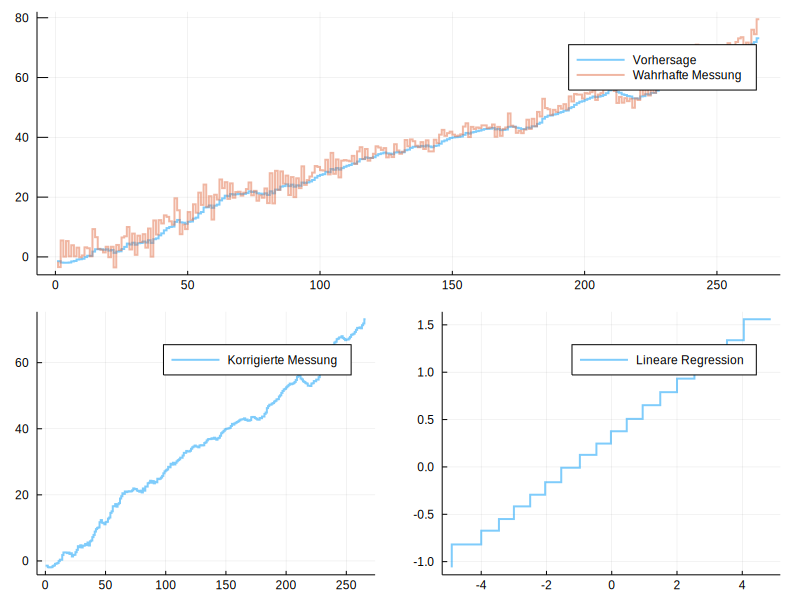

In [9]:
A = 1 # Zustandsübergangsmatrix
G = 1 # Messabbildung Matrix
Q = 0.5 
R = mean(data[:GMSL]) * error

x̂_0 = data[1, :GMSL]
# x̂_0 = f(1)
Σ_0 = -1.6

y = (step) -> data[step, :GMSL] #+ 0.2 * rand(Normal(-R, R))

model = KalmanFilter.Kalman(A, Q, G, R, x̂_0, Σ_0)

length = 266
predicted = zeros(length)
fusioned = zeros(length)
confidence = zeros(length)
gains = zeros(length)
for i = 1:length
    y_cur = y(i)
    
    
    KalmanFilter.fusion(model, y_cur)
    fusioned[i] = model.x̂
    
    
    KalmanFilter.predict(model)
    predicted[i] = model.x̂
    
    confidence[i] = model.Σ
    gains[i] = KalmanFilter.K(model)
end
l = @layout [a; b c]
prediction = plot(predicted, label = "Vorhersage")
plot!(data[:Row], data[:GMSL], label = "Wahrhafte Messung")
fusioned = plot(fusioned, label = "Korrigierte Messung")
linear_regression = plot(f, label = "Lineare Regression")
plot(prediction, fusioned, linear_regression, layout = l)
# plot(xlim = (1, length), ylim = (-3, f(length)), layout = (4, 1)) 

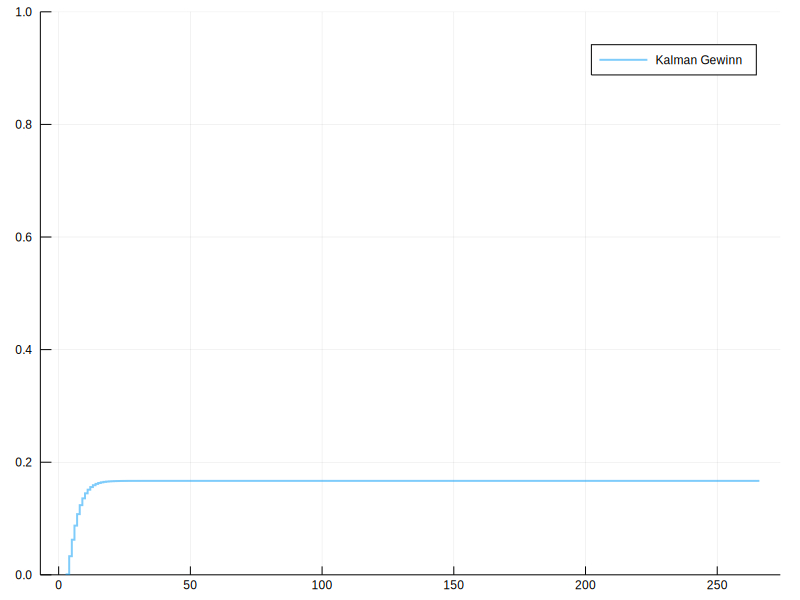

In [10]:
plot(gains[1:length], label = "Kalman Gewinn", ylim = (0, 1), linewidth = 2)

In [11]:
filteredData = DataFrame(Row = 1:length, GMSL_Filtered = fusioned)
describe(filteredData)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Union…,Union…,Union…,Union…,Nothing,DataType
1,Row,133.5,1,133.5,266,,,Int64
2,GMSL_Filtered,,,,,1,,Plot{GRBackend}


In [12]:
filteredModel = fit(LinearModel, @formula(GMSL_Filtered ~ Row), filteredData)
g(x) = coef(filteredModel)[2] * x + coef(filteredModel)[1]
plot(xlim = (1, 200))
plot!(filteredData[:GMSL_Filtered], linewidth = 2, label = "Gefilterte Daten", linestyle=:solid)
plot!(f, 1, size(data)[1], label = "Lineare Schätzung <br /> des Modells")
# plot!(g, 1, size(data)[1], label = "Lineare Schätzung des <br /> gefilterten Modells")

ArgumentError: ArgumentError: only one level found: Plot{Plots.GRBackend() n=1} (need at least two to compute contrasts).